<font size="5"><b>Телеком</b>
    
<b>Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.</b>
    
<b>Целью данного проекта является обучение модели для предсказания оттока клиентов, а также выявлению закономерностей и взаимосвязей с другими параментрами, для дальнейшей корректировки тарифной политики оператора.</b>    

<b>План работы:</b>

<b>1. Загружу данные.</b>

<b>2. Ознакомлюсь с содержанием и качеством информации.</b>

<b>3. Выполню анализ данных.</b>

<b>4. Подготовлю данные к обучению, создам новые необхоимые признаки и выделю целевой признак, обрабработаю категориальные признаки.</b>

<b>5. Обучу три модели, используя кросс-валидацию для поучения лучших метрик.</b>

<b>6. Проанализирую точность предсказаний: метрики ROC-AUC и Accuracy.</b>

<b>7. Сделаю финальный отчет о выполнении проекта.</b>

# 1. Загрузка данных.

In [52]:
import os
import phik
from phik import resources
from phik.report import plot_correlation_matrix

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimpy import clean_columns

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, roc_curve, accuracy_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
con1 = 'C:\\Users\\sofat\\Desktop\\База\\contract.csv'
con2 = '/datasets/final_provider/contract.csv'
con3 = 'C:\\Users\\User\\Desktop\\База\\contract.csv'

if os.path.exists(con1):
    contract = pd.read_csv(con1)
elif os.path.exists(con2):
    contract = pd.read_csv(con2)
elif os.path.exists(con3):
    contract = pd.read_csv(con3)    
else:
    print('Something is wrong')

In [3]:
int1 = 'C:\\Users\\sofat\\Desktop\\База\\internet.csv'
int2 = '/datasets/final_provider/internet.csv'
int3 = 'C:\\Users\\User\\Desktop\\База\\internet.csv'

if os.path.exists(int1):
    internet = pd.read_csv(int1)
elif os.path.exists(int2):
    internet = pd.read_csv(int2)
elif os.path.exists(int3):
    internet = pd.read_csv(int3)    
else:
    print('Something is wrong')

In [4]:
per1 = 'C:\\Users\\sofat\\Desktop\\База\\personal.csv'
per2 = '/datasets/final_provider/personal.csv'
per3 = 'C:\\Users\\User\\Desktop\\База\\personal.csv'

if os.path.exists(per1):
    personal = pd.read_csv(per1)
elif os.path.exists(con2):
    personal = pd.read_csv(per2)
elif os.path.exists(con3):
    personal = pd.read_csv(per3)    
else:
    print('Something is wrong')

In [5]:
phn1 = 'C:\\Users\\sofat\\Desktop\\База\\phone.csv'
phn2 = '/datasets/final_provider/phone.csv'
phn3 = 'C:\\Users\\User\\Desktop\\База\\phone.csv'

if os.path.exists(phn1):
    phone = pd.read_csv(phn1)
elif os.path.exists(phn2):
    phone = pd.read_csv(phn2)
elif os.path.exists(phn3):
    phone = pd.read_csv(phn3)    
else:
    print('Something is wrong')

# 2. Ознакомление с содержанием и качеством информации.

In [6]:
dfs = [contract, internet, personal, phone]

In [7]:
for i in dfs:
    print(f'Количество пропусков в датафрейме:')
    print(i.isna().sum())
    print('==========================')
    print(f'Общая информация о датафрейме:')
    print(i.info())
    print('==========================')
    print(f'Количество явных дубликатов в датафрейме:')
    print(i.duplicated().sum())
    print('==========================')

Количество пропусков в датафрейме:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Количество явных дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
customerID          0
InternetS

<b>У всех таблиц есть одинаковй столбец customerID, по которому я проведу объединение их в один датафрейм, чтобы с данными было проще работать.<b/>

In [8]:
df = contract.merge(personal, how='left', on = 'customerID').merge(
    internet, how='left', on = 'customerID').merge(phone, how='left', on = 'customerID')

In [9]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


<b>Названия столбцов имеют верблюжий стиль, я приведу их к змеиному стилю и нижнему регистру.<b/>

In [11]:
cols = df.columns.tolist()
messy_df = pd.DataFrame(columns=cols, index=[0], data=[range(len(cols))])
new_cols = clean_columns(messy_df)
new_cols.columns.tolist()
df.columns = new_cols.columns

19 column names have been cleaned

In [12]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [13]:
df.describe()

,monthly_charges,senior_citizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


In [14]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

<b>В объединенной таблице появились пропуски в столбцах с данными о дополнительных услугах, это произошло потому, что не обо всех пользователях были внесены данные в таблицы дополнительных услуг, скорее всего потому, что данные клиенты их не использовали, то есть логично будет заполнить их значением No. Но так как большинство данных можно привести к булевому типу, то есть заменить Yes и No на 1 и 0, то я заполню пропуски нулями и приведу все возможные данные к булевому типу.<b/>
    
<b>Также поменяю типы данных в некоторых столбцах на соответствующие.</b>

In [15]:
for i in df.columns:
    print('**********')
    print(i)
    print(df[i].value_counts())

**********
customer_id
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customer_id, Length: 7043, dtype: int64
**********
begin_date
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64
**********
end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64
**********
type
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64
**********
paperless_billing
Yes    4171
No     2872
Name: paperless_billing, dtype: int64
**********
payment_method
Electronic check             2365
Mailed check                 1612
Bank tra

In [16]:
df['gender'] = df['gender'].replace(['Male'], 1).replace(['Female'], 0).astype(int)

In [17]:
cols_null = ['internet_service', 'online_security', 'online_backup', 'device_protection',
             'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [18]:
for i in cols_null:
    df[i] = df[i].fillna(0)

In [19]:
cols_bull = ['senior_citizen', 'dependents', 'partner', 'multiple_lines', 'paperless_billing',
           'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [20]:
for i in cols_bull:
    df[i] = df[i].replace('No', 0).replace('Yes', 1).astype(int)

In [21]:
df['total_charges'] = df['total_charges'].replace(' ', 0).astype('float')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   int32  
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   int32  
 9   senior_citizen     7043 non-null   int32  
 10  partner            7043 non-null   int32  
 11  dependents         7043 non-null   int32  
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   int32  
 14  online_backup      7043 non-null   int32  
 15  device_protection  7043 non-null   int32  
 16  tech_support       7043 

<b>Три признака type, internet_service и payment_method, которые имеют больше вариантов, чем два, я тоже закодирую вручную.<b/>

In [23]:
df['payment_method'] = df['payment_method'].replace(
    'Electronic check', 0).replace('Mailed check', 1).replace(
    'Bank transfer (automatic)', 2).replace('Credit card (automatic)', 3).astype(int)

df['internet_service'] = df['internet_service'].replace('Fiber optic', 1).replace('DSL', 2).astype(int)
df['type'] = df['type'].replace('Month-to-month', 0).replace('One year', 1).replace('Two year', 2).astype(int)

In [24]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,0,1,0,29.85,29.85,0,0,1,0,2,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,No,1,0,1,56.95,1889.50,1,0,0,0,2,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,1,53.85,108.15,1,0,0,0,2,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,No,1,0,2,42.30,1840.75,1,0,0,0,2,1,0,1,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,0,70.70,151.65,0,0,0,0,1,0,0,0,0,0,0,0


<b>Вывод первичного анализа:</b>

<b>Я загрузила и ознакомилась с данными.</b>
<b> Данные полные, пропусков и дубликатов нет. Типы данных в таблицах не всегда соответствуют содержимому, я привела их у нудным типам. Таблицы содержат данные о 7043 клиентах, что должно быть достаточным для обучения модели. </b>
<b> В таблицах о клиентах и о контрактах одинаковое количество записей, то есть они отображают данные обо всех клиентах. в таблицах о телефонии и иинтеренте меньше записей, скорее всего это связано с тем, чтобы не все клиенты пользуются допольнительными услугами, и нужно будет заполнить пропуски, которые образуются после объединения данных.  </b>

# Анализ данных

<b>В качестве целевого признака нужно выбрать 'EndDate', который я скопирую в признак target, а изначальный сталбец оставлю в датафрейме для аназила. Те пользователи, которые не закончили договор, им присвою значение 0, остальные окончившие договор будут иметь значение 1.</b>

In [25]:
df['end_date'].isna().sum()

0

In [26]:
df['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [27]:
df['target'] = df['end_date'].copy()
df['target'] = df['target'].replace({'No': 0})
df.loc[df['target'] != 0, ['target']] = 1
df['target'] = df['target'].astype(int)
df['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

0    0.73463
1    0.26537
Name: target, dtype: float64


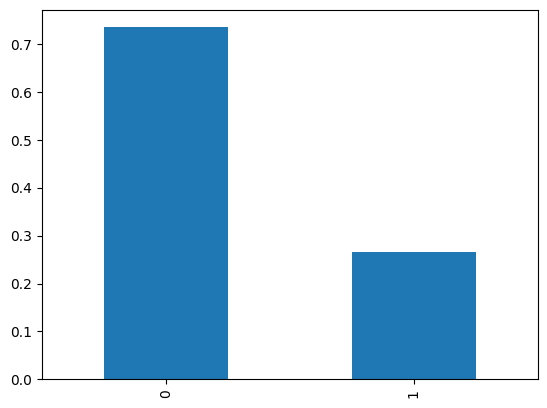

In [28]:
class_frequency = df['target'].value_counts(normalize=True) 
print(class_frequency)
class_frequency.plot(kind='bar');

<b>Присутствует явный дисбаланс классов соотошение 1 к 0 примерно 1 к 3.</b>

In [29]:
df['end_date'] = df['end_date'].replace(['No'], ['2020-02-01'])
df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d')
df['begin_date'] = pd.to_datetime(df['begin_date'], format = '%Y-%m-%d')
df['total_time'] = abs(df['end_date'] - df['begin_date']).dt.days
df['total_time'].head()

0      31
1    1036
2      61
3    1371
4      61
Name: total_time, dtype: int64

In [30]:
df['total_time'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: total_time, dtype: float64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   int32         
 4   paperless_billing  7043 non-null   int32         
 5   payment_method     7043 non-null   int32         
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   int32         
 9   senior_citizen     7043 non-null   int32         
 10  partner            7043 non-null   int32         
 11  dependents         7043 non-null   int32         
 12  internet_service   7043 non-null   int32         
 13  online_security    7043 non-null   int32         
 14  online_b

<b>Теперь проведу анализ взаимосвязи помесячных и общих трат пользователей и их оттока.</b>

In [32]:
df['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

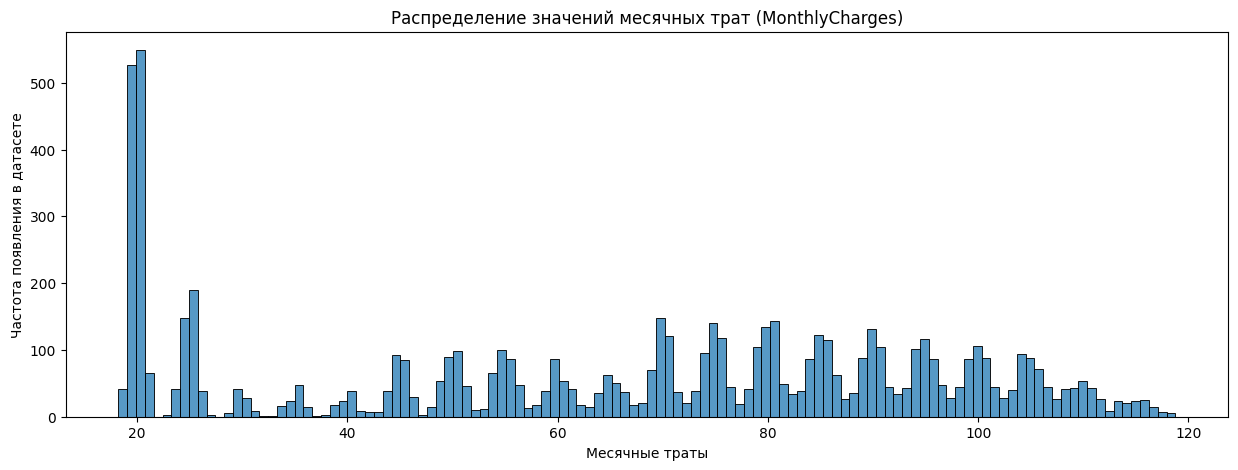

In [33]:
plt.figure(figsize=[15, 5])
sns.histplot(df['monthly_charges'], bins = 120)
plt.title('Распределение значений месячных трат (MonthlyCharges)')
plt.xlabel('Месячные траты')
plt.ylabel('Частота появления в датасете');

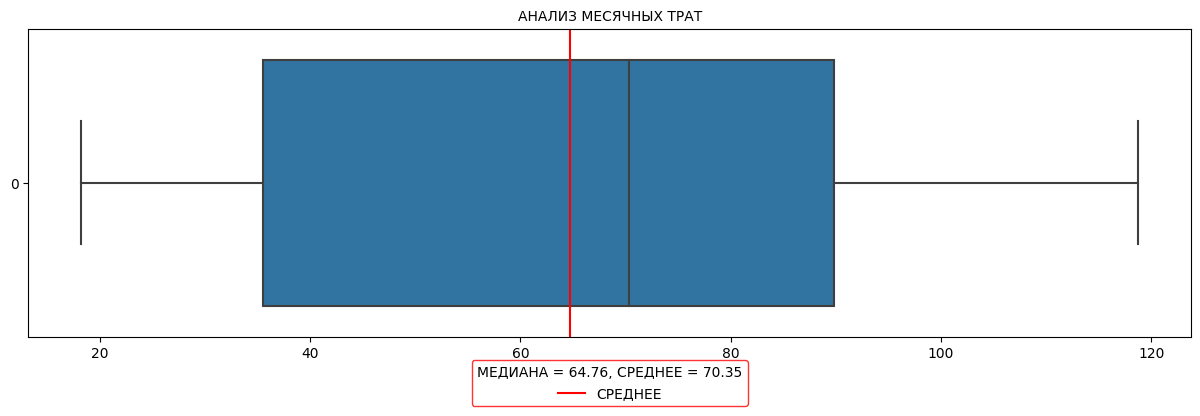

In [34]:
plt.figure(figsize=[15, 4])
plt.title(f'АНАЛИЗ МЕСЯЧНЫХ ТРАТ', fontsize=10)
sns.boxplot(data=df['monthly_charges'], orient='h')
plt.axvline(np.mean(df['monthly_charges']), 
            color='r', 
            linestyle='-',
            label='СРЕДНЕЕ')
median = np.mean(df['monthly_charges'])
mean = np.median(df['monthly_charges'])
plt.legend(title=f'МЕДИАНА = {median:.2f}, СРЕДНЕЕ = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',          
           bbox_to_anchor=(0.5, -0.15));

<b>В соответствии с помеcячной оплатой можно разбить клиентов на три категории:
    
    те, кто платит от 10 до 40 (base);
    
    те, кто платит от 40 до 80 (standart);
    
    ту, кто платят от 80 до 12 (high).
</b>

In [35]:
df['monthly_charges_group'] = pd.qcut(df['monthly_charges'], 3, labels=['base', 'standart', 'high'])

In [36]:
df['monthly_charges_group'].value_counts(normalize=True)

base        0.333807
high        0.333239
standart    0.332955
Name: monthly_charges_group, dtype: float64

<b>Клиенты получились равномерно распределены по группам. Проанализирую по группам клиентов, какие из них чаще склонных к уходу.</b>

In [37]:
base = df.query('monthly_charges_group == "base"')
standart = df.query('monthly_charges_group == "standart"')
high = df.query('monthly_charges_group == "high"')

In [38]:
stats_pivot_on_groups = pd.DataFrame()
stats_pivot_on_groups['base'] = base.describe().T['mean']
stats_pivot_on_groups['standart'] = standart.describe().T['mean']
stats_pivot_on_groups['high'] = high.describe().T['mean']
stats_pivot_on_groups

,base,standart,high
type,0.811144,0.558209,0.701747
paperless_billing,0.383667,0.626866,0.766510
payment_method,1.421097,1.290832,1.234768
monthly_charges,27.988622,69.036333,97.326438
total_charges,715.369226,1954.691919,4171.530933
gender,0.518077,0.494670,0.501491
senior_citizen,0.070608,0.160768,0.255219
partner,0.435559,0.447335,0.566255
dependents,0.361548,0.281023,0.256072
internet_service,0.701829,1.605117,1.075415


<b>Из таблицы видно, что клиенты третей группы больше пользуются услугами. Первая группа практически вообще не пользуется дополнительными услугами (доля не превшает 10%)

Примечательно, что:

доля пользователей, использующих безналичный расчет растет от 38% в первой группе, до 62% во второй группе, и до 76% в третьей группе;

среди третьей группы больше пенсионеров (7% первая группа, 16% - вторая группа, 25% - третья группа);

в третей группе больше клиентов, состоящих в браке (43,5% первая группа, 44,7% - вторая группа, 56,6% - третья группа);

иждевенцев, наоборот, больше в первой группе - 36%, во второй группе 28%, в третьей 25,6%;

среди третьей группы только 7% пользователей продолжают использовать интернет соединение через через телефонную линию, во второй группе это значение вырастает до 59%, в третьей 38%.</b>

<b>И самое важное: наибольший процент оттока клиентов наблюдается в группе  - 34%, во второй группе 29,6%, в первой 15,8%. Хотя показатель общего времени договора тоже самый высокий в среднем в группе с максимальной помесячной оплатой. То есть опять возникает впечатление, что отток составляют те клиенты, которые пришли недавно, платили много, и их это не утроило. А те клиенты, у которых помесячная оплата высокая, которые пользуются дополнительноыми услугами, но пришли давно, сохраняют лояльность.</b>

<b>Проанализируем также признак total_time</b>

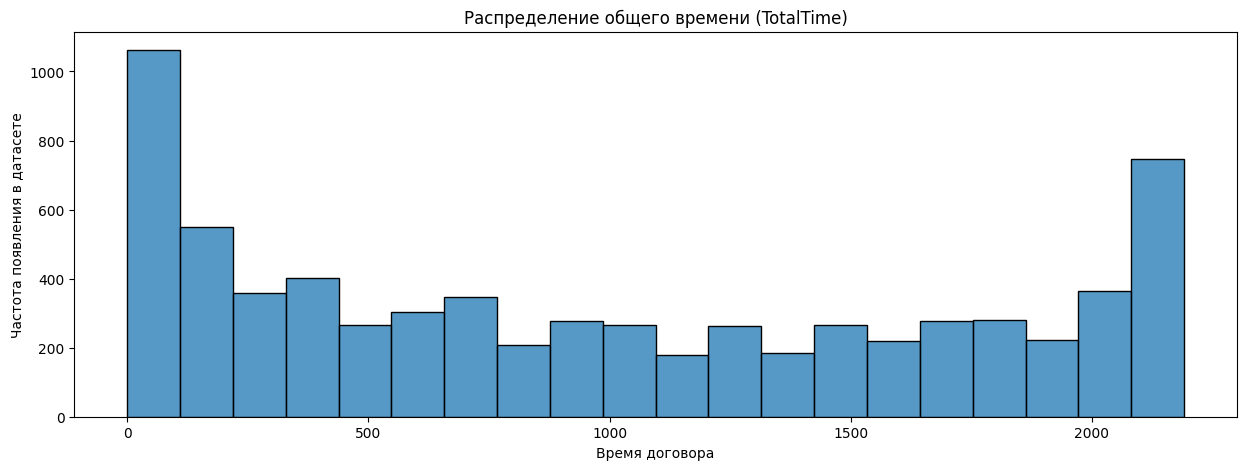

In [39]:
plt.figure(figsize=[15, 5])
sns.histplot(df['total_time'], bins = 20)
plt.title('Распределение общего времени (TotalTime)')
plt.xlabel('Время договора')
plt.ylabel('Частота появления в датасете');

In [40]:
df['total_time_group'] = pd.qcut(df['total_time'], 3, labels=['base_t', 'standart_t', 'high_t'])

In [41]:
df['total_time_group'].value_counts(normalize=True)

base_t        0.336646
standart_t    0.336362
high_t        0.326991
Name: total_time_group, dtype: float64

In [42]:
base_t = df.query('total_time_group == "base_t"')
standart_t = df.query('total_time_group == "standart_t"')
high_t = df.query('total_time_group == "high_t"')

In [43]:
stats_pivot_on_groups = pd.DataFrame()
stats_pivot_on_groups['base_t'] = base_t.describe().T['mean']
stats_pivot_on_groups['standart_t'] = standart_t.describe().T['mean']
stats_pivot_on_groups['high_t'] = high_t.describe().T['mean']
stats_pivot_on_groups

,base_t,standart_t,high_t
type,0.136651,0.552554,1.402518
paperless_billing,0.590046,0.590122,0.596613
payment_method,0.870097,1.306458,1.783760
monthly_charges,56.490953,64.371190,73.678333
total_charges,317.483277,1948.177374,4640.982914
gender,0.500211,0.506543,0.507599
senior_citizen,0.147617,0.173913,0.165002
partner,0.268241,0.479105,0.708207
dependents,0.210460,0.309413,0.381242
internet_service,1.112611,1.113128,1.156318


<b>Из анализа признака total_time видно, что меньше всего клиентов, только 9,6 % уходят из категории длительного пользования услугами, а 46% уходящих клиентов из первой группы с коротким периодом договора. То есть, чем дольше пользователь является клиентом компании, тем он более лоялен и меньше вероятности, что он уйдет. Поэтому предложения для клиентов, которые должны стимулировать их не расторгать договор должны быть направлены в первую очередь на новых клиентов.</b>

In [44]:
df['total_charges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

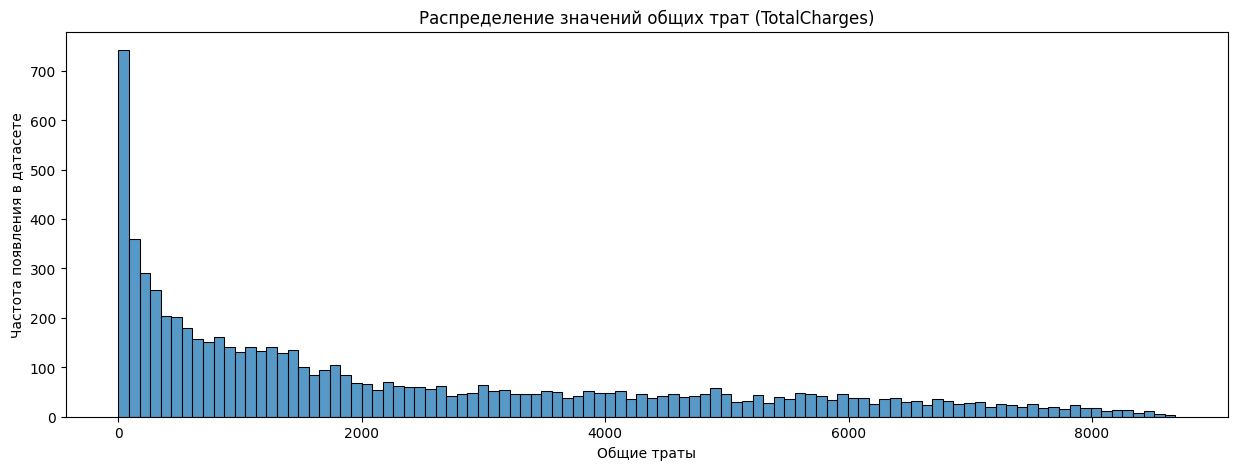

In [45]:
plt.figure(figsize=[15, 5])
sns.histplot(df['total_charges'], bins = 100)
plt.title('Распределение значений общих трат (TotalCharges)')
plt.xlabel('Общие траты')
plt.ylabel('Частота появления в датасете');

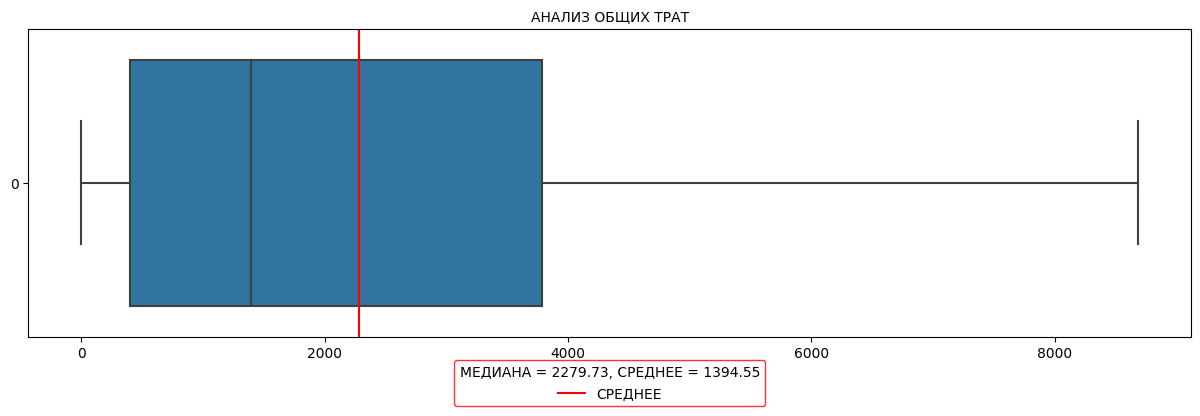

In [46]:
plt.figure(figsize=[15, 4])
plt.title(f'АНАЛИЗ ОБЩИХ ТРАТ', fontsize=10)
sns.boxplot(data=df['total_charges'], orient='h')
plt.axvline(np.mean(df['total_charges']), 
            color='r', 
            linestyle='-',
            label='СРЕДНЕЕ')
median = np.mean(df['total_charges'])
mean = np.median(df['total_charges'])
plt.legend(title=f'МЕДИАНА = {median:.2f}, СРЕДНЕЕ = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',          
           bbox_to_anchor=(0.5, -0.15));

<b>Распределение суммарных трат напоминает логнормальное распределение. Нужно понять, почему могут встречаться нулевые значения в общих расходах. Среднее значение и медиана различаются довольно сильно, потому что есть и нулевые значения и те, кто был клиентом компании совсем не долго.<b/>

In [47]:
df.query('total_charges == 0')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,total_time,monthly_charges_group,total_time_group
488,4472-LVYGI,2020-02-01,2020-02-01,2,1,2,52.55,0.0,0,0,...,0,1,1,1,0,0,0,0,standart,base_t
753,3115-CZMZD,2020-02-01,2020-02-01,2,0,1,20.25,0.0,1,0,...,0,0,0,0,0,0,0,0,base,base_t
936,5709-LVOEQ,2020-02-01,2020-02-01,2,0,1,80.85,0.0,0,0,...,1,1,0,1,1,0,0,0,standart,base_t
1082,4367-NUYAO,2020-02-01,2020-02-01,2,0,1,25.75,0.0,1,0,...,0,0,0,0,0,1,0,0,base,base_t
1340,1371-DWPAZ,2020-02-01,2020-02-01,2,0,3,56.05,0.0,0,0,...,1,1,1,1,0,0,0,0,standart,base_t
3331,7644-OMVMY,2020-02-01,2020-02-01,2,0,1,19.85,0.0,1,0,...,0,0,0,0,0,0,0,0,base,base_t
3826,3213-VVOLG,2020-02-01,2020-02-01,2,0,1,25.35,0.0,1,0,...,0,0,0,0,0,1,0,0,base,base_t
4380,2520-SGTTA,2020-02-01,2020-02-01,2,0,1,20.00,0.0,0,0,...,0,0,0,0,0,0,0,0,base,base_t
5218,2923-ARZLG,2020-02-01,2020-02-01,1,1,1,19.70,0.0,1,0,...,0,0,0,0,0,0,0,0,base,base_t
6670,4075-WKNIU,2020-02-01,2020-02-01,2,0,1,73.35,0.0,0,0,...,1,1,1,1,0,1,0,0,standart,base_t


<b>Все пользователи, у которых есть нулевые значения в общих расходах, заключили контракты 1 февраля 2020 года и не вносили еще оплату.<b/>

interval columns not set, guessing: ['type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'target', 'total_time']


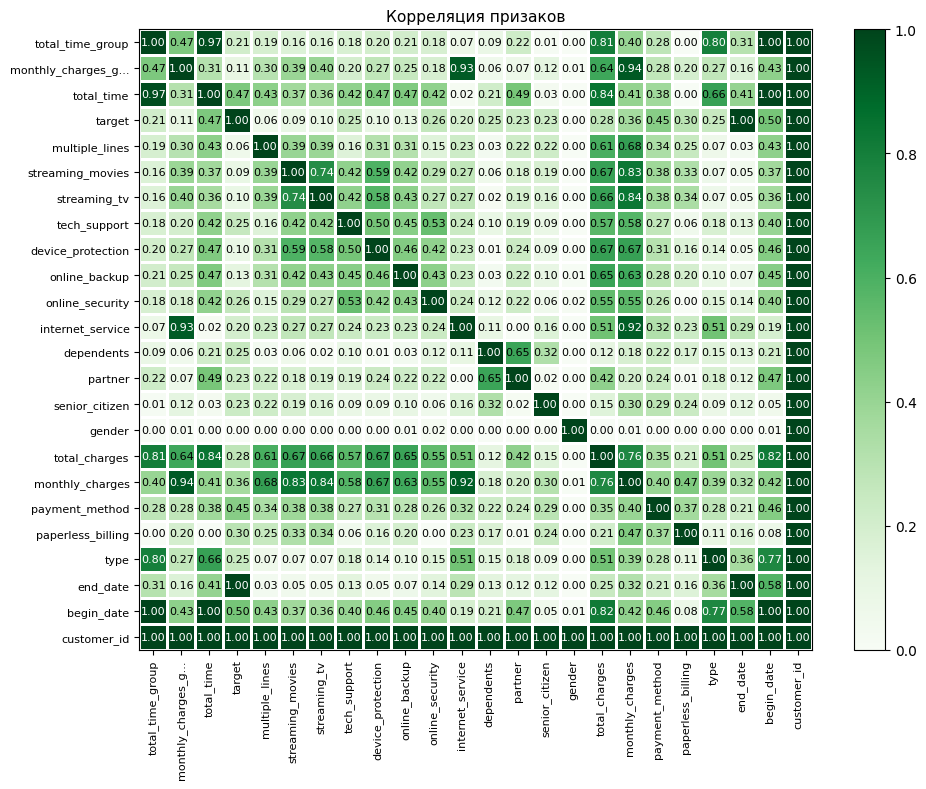

In [57]:
matrix = df.phik_matrix()
plot_correlation_matrix(matrix.values, 
                        x_labels=matrix.columns, 
                        y_labels=matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция призаков", 
                        fontsize_factor=0.8, 
                        figsize=(10, 8))
plt.tight_layout()

interval columns not set, guessing: ['type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'target', 'total_time']


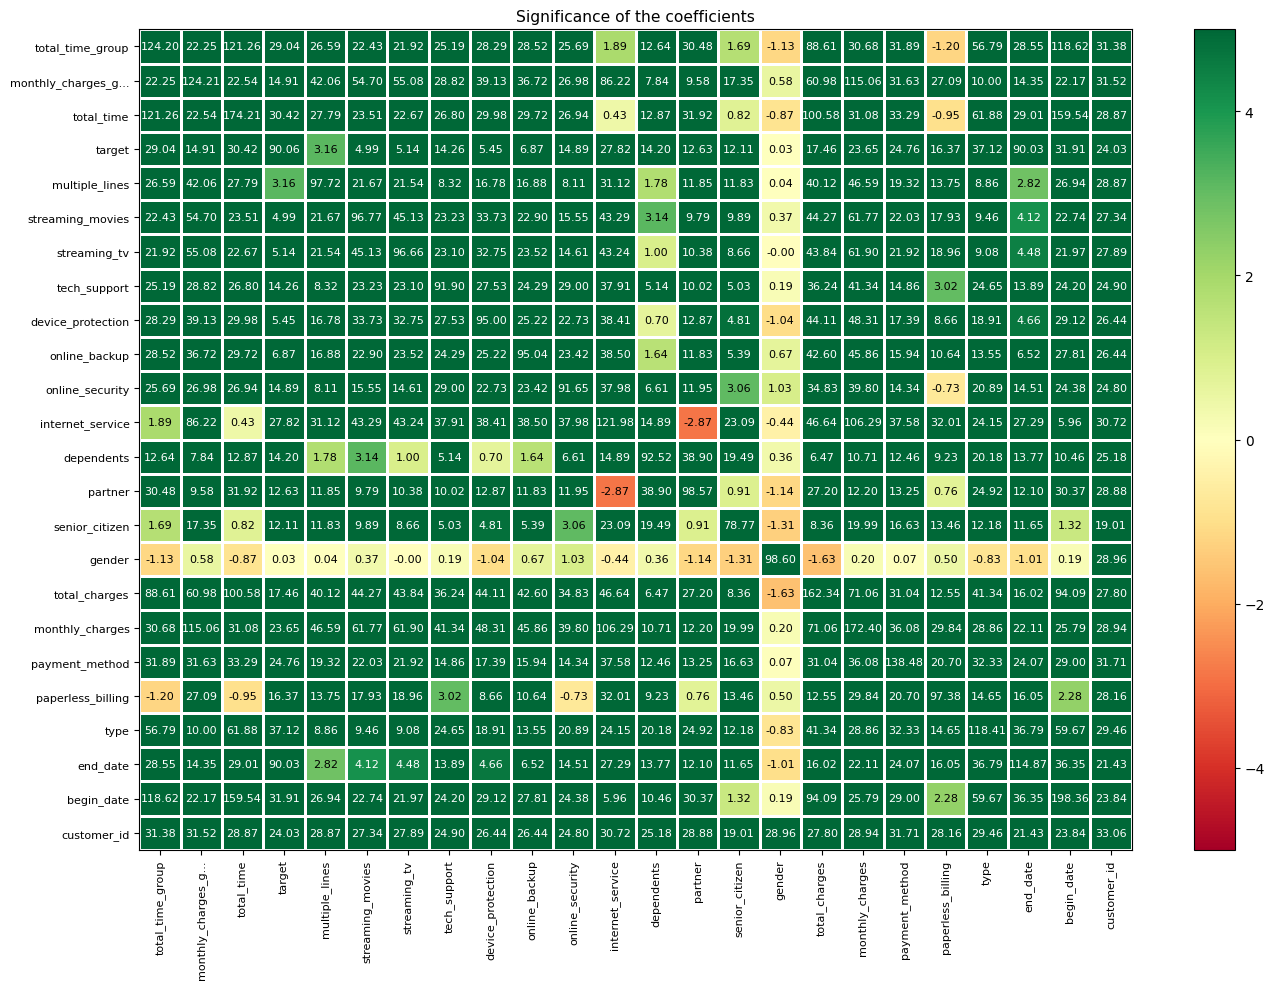

In [60]:
significance_overview = df.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(14, 10))
plt.tight_layout()

<b>Наибольшая заивисмость у целевого признака заметна от даты начала договора, способа оплаты и общего времени, на протяжении которого человек был клиентом компании. Продолжаю предполагать невыгодные условия тарифного плана, с помощью которых клиентов сначаал привлекли, но который оказался основан, возможно, на предоставлении слишком дорогих услуг, не отвечающих ожиданиям. Интересно, что есть очень большая корреляция между использованием антивирусов и техподдержки и тем, является ли человек пенсионером или нет.</b>

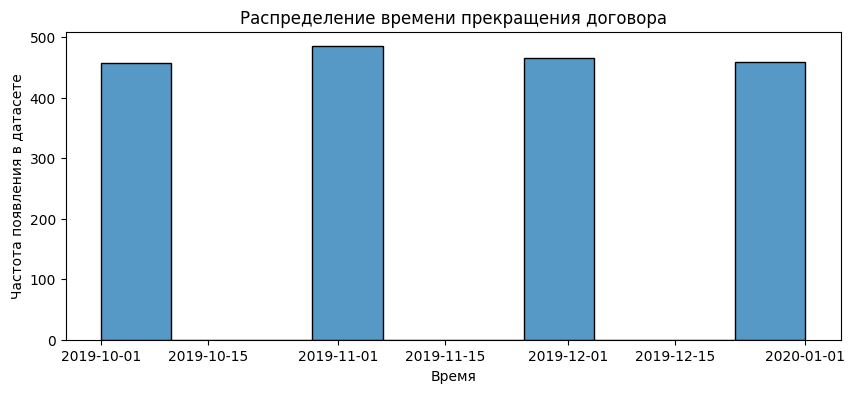

In [61]:
plt.figure(figsize=[10, 4])
sns.histplot(df.query('end_date != "2020-02-01"')['end_date'], bins = 10)
plt.title('Распределение времени прекращения договора')
plt.xlabel('Время')
plt.ylabel('Частота появления в датасете');

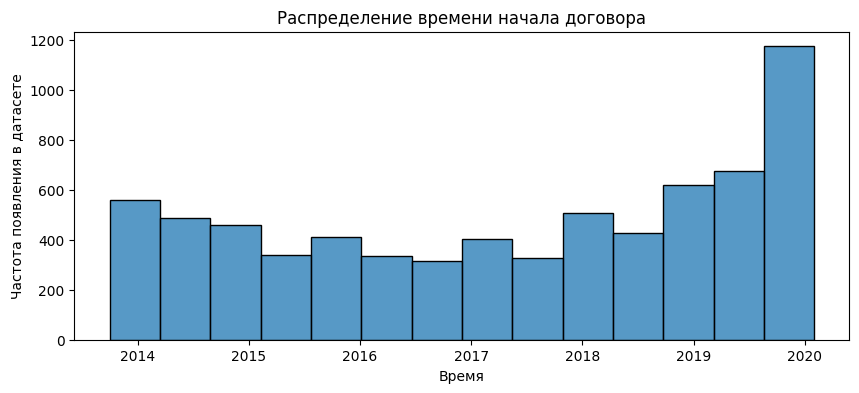

In [62]:
plt.figure(figsize=[10, 4])
sns.histplot(df['begin_date'], bins = 14)
plt.title('Распределение времени начала договора')
plt.xlabel('Время')
plt.ylabel('Частота появления в датасете');

<b>Периоды оттока клиентов дискретны и приходятся на начало месяца, возможно это связано с особенностью заключения и расторжения договоров, которые происходят только с первых чисел месяца. Вообще примечательно, что в 2020 году приток новых клиентов заметно увеличился, но в тоже время в конце 2019 и начале 2020 начался их отток. Предположу, что это может быть связано с новыми тарифными планами и дополнительными услугами, которые вначале кажутся привлекательными для клиентов, но в процессе использования не удовлетворяют их потребностей.</b>

In [69]:
after = df.query('begin_date >= "2019-09-01"')['target'].value_counts(normalize=True)
befor = df.query('begin_date < "2019-09-01"')['target'].value_counts(normalize=True)
print('Доля оставшихся и ушедших клиентов, которые заключили договор после 1 сентября 2019 года:')
print(after)
print('===================================')
print('Доля оставшихся и ушедших клиентов, которые заключили договор до 1 сентября 2019 года:')
print(befor)

Доля оставшихся и ушедших клиентов, которые заключили договор после 1 сентября 2019 года:
0    0.533617
1    0.466383
Name: target, dtype: float64
Доля оставшихся и ушедших клиентов, которые заключили договор до 1 сентября 2019 года:
0    0.774881
1    0.225119
Name: target, dtype: float64


<b>Проанализировав клиентов по дате заключения договора, тоже видно, что доля клиентов, пришедших после сентября и расторгнувших договор, более чем в два раза выше, чем доля ушедших клиентов, заключивших договор до сетября 2019 года. То есть, почти половина новых клиентов в течение 4 месяцев ушли.</b>

# Подготовка данных к обучению.

In [70]:
RANDOM_STATE = 300123

<b>Признаки с датой для обучения не нужны. Удалю их, а также ID пользователя.</b>

In [71]:
df = df.drop(['begin_date', 'end_date', 'customer_id', 'monthly_charges_group', 'total_time_group'], axis=1)

In [72]:
df.shape

(7043, 19)

In [73]:
features = df.drop(['target'], axis=1)
target = df['target']

In [74]:
features_train, features_test, target_train, target_test = train_test_split(
                                                features, target, test_size=0.25, random_state=12345, stratify=target)

# Обучение моделей. 

<b> Обучу три разных модели LogisticRegression, RandomForestClassifier и CatBoostClassifier, для каждой применю метод кросс-валидации и вычислю метрики ROC-AUC и Accurasy.</b>

In [75]:
scaler = StandardScaler()

features_s = scaler.fit_transform(features_train[features.columns.values])

In [76]:
model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=1000, class_weight='balanced')
 
model_lr.fit(features_s, target_train)
 
roc_auc_lr = cross_val_score(model_lr, features_s, target_train, cv=5, scoring='roc_auc').mean()
acc_lr = cross_val_score(model_lr, features_s, target_train, cv=5, scoring='accuracy').mean()
print("Метрика ROC-AUC Логистической регрессии:", roc_auc_lr)
print("Метрика Accurasy Логистической регрессии:", acc_lr)

Метрика ROC-AUC Логистической регрессии: 0.841853558915403
Метрика Accurasy Логистической регрессии: 0.7440352555832688


In [77]:
%%time
grid = { 
    'n_estimators': range(400, 500, 20),
    'max_depth' : range (4, 20, 2),
    'random_state' : [300123],
    'class_weight': ['balanced', None]
}

rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 5, scoring='roc_auc')
rf_cv.fit(features_train, target_train)
best_grid = rf_cv.best_params_
print('лучшие параметры:', rf_cv.best_params_)
print('лучшая метрика:', rf_cv.best_score_)

лучшие параметры: {'class_weight': None, 'max_depth': 8, 'n_estimators': 480, 'random_state': 300123}
лучшая метрика: 0.8619397097862148
CPU times: total: 12min 8s
Wall time: 12min 10s


In [78]:
%%time
model_f = RandomForestClassifier(**best_grid)

model_f.fit(features_train, target_train)

roc_auc_f = cross_val_score(model_f, features_train, target_train, cv=5, scoring='roc_auc').mean()
acc_f = cross_val_score(model_f, features_train, target_train, cv=5, scoring='accuracy').mean()        
             
print("Метрика ROC-AUC Случайный лес:", roc_auc_f )
print("Метрика Accurasy Случайный лес:", acc_f)

Метрика ROC-AUC Случайный лес: 0.8619397097862148
Метрика Accurasy Случайный лес: 0.8191966973423928
CPU times: total: 19.5 s
Wall time: 19.5 s


In [89]:
%%time
grid_c = { 
    'random_state' : [300123],
    'learning_rate': [0.05, 0.1, 0.15],
    'boosting_type': ['Ordered'],
    'custom_loss': ['AUC'],
    'verbose': range(50, 400, 50),
    'n_estimators': range(1400, 1600, 100)       
}

cat_cv = GridSearchCV(estimator=CatBoostClassifier(), param_grid=grid_c, cv=7, scoring='roc_auc')
cat_cv.fit(features_train, target_train)
best_grid_c = cat_cv.best_params_

0:	learn: 0.6655962	total: 8.13ms	remaining: 11.4s
50:	learn: 0.3721937	total: 459ms	remaining: 12.1s
100:	learn: 0.3523460	total: 879ms	remaining: 11.3s
150:	learn: 0.3381920	total: 1.31s	remaining: 10.9s
200:	learn: 0.3170604	total: 1.75s	remaining: 10.4s
250:	learn: 0.3010474	total: 2.23s	remaining: 10.2s
300:	learn: 0.2943237	total: 2.68s	remaining: 9.77s
350:	learn: 0.2893730	total: 3.12s	remaining: 9.32s
400:	learn: 0.2818935	total: 3.56s	remaining: 8.87s
450:	learn: 0.2765736	total: 4.01s	remaining: 8.44s
500:	learn: 0.2689108	total: 4.47s	remaining: 8.02s
550:	learn: 0.2649292	total: 4.92s	remaining: 7.58s
600:	learn: 0.2619854	total: 5.38s	remaining: 7.14s
650:	learn: 0.2604828	total: 5.85s	remaining: 6.73s
700:	learn: 0.2561734	total: 6.31s	remaining: 6.29s
750:	learn: 0.2543657	total: 6.75s	remaining: 5.83s
800:	learn: 0.2525520	total: 7.2s	remaining: 5.38s
850:	learn: 0.2513707	total: 7.65s	remaining: 4.94s
900:	learn: 0.2505288	total: 8.13s	remaining: 4.5s
950:	learn: 0.24

650:	learn: 0.2739655	total: 6.09s	remaining: 7s
700:	learn: 0.2701986	total: 6.55s	remaining: 6.53s
750:	learn: 0.2671048	total: 7s	remaining: 6.05s
800:	learn: 0.2656513	total: 7.48s	remaining: 5.59s
850:	learn: 0.2635872	total: 7.95s	remaining: 5.13s
900:	learn: 0.2614671	total: 8.41s	remaining: 4.66s
950:	learn: 0.2582263	total: 8.88s	remaining: 4.19s
1000:	learn: 0.2526425	total: 9.33s	remaining: 3.72s
1050:	learn: 0.2497202	total: 9.79s	remaining: 3.25s
1100:	learn: 0.2479116	total: 10.2s	remaining: 2.78s
1150:	learn: 0.2436483	total: 10.7s	remaining: 2.32s
1200:	learn: 0.2415364	total: 11.2s	remaining: 1.85s
1250:	learn: 0.2397494	total: 11.7s	remaining: 1.39s
1300:	learn: 0.2379811	total: 12.1s	remaining: 921ms
1350:	learn: 0.2365105	total: 12.6s	remaining: 456ms
1399:	learn: 0.2356029	total: 13s	remaining: 0us
0:	learn: 0.6576855	total: 18.9ms	remaining: 26.5s
50:	learn: 0.3751850	total: 472ms	remaining: 12.5s
100:	learn: 0.3524293	total: 909ms	remaining: 11.7s
150:	learn: 0.3

1200:	learn: 0.2441674	total: 12.4s	remaining: 2.05s
1350:	learn: 0.2399945	total: 13.9s	remaining: 505ms
1399:	learn: 0.2391365	total: 14.4s	remaining: 0us
0:	learn: 0.6594393	total: 21.2ms	remaining: 29.6s
150:	learn: 0.3414893	total: 1.46s	remaining: 12.1s
300:	learn: 0.3023032	total: 2.77s	remaining: 10.1s
450:	learn: 0.2811632	total: 4.2s	remaining: 8.84s
600:	learn: 0.2708382	total: 5.59s	remaining: 7.43s
750:	learn: 0.2632183	total: 7.03s	remaining: 6.08s
900:	learn: 0.2548848	total: 8.48s	remaining: 4.7s
1050:	learn: 0.2500897	total: 9.97s	remaining: 3.31s
1200:	learn: 0.2449775	total: 11.4s	remaining: 1.89s
1350:	learn: 0.2403132	total: 12.8s	remaining: 463ms
1399:	learn: 0.2390529	total: 13.2s	remaining: 0us
0:	learn: 0.6598951	total: 15.7ms	remaining: 22s
150:	learn: 0.3423948	total: 1.33s	remaining: 11s
300:	learn: 0.3032838	total: 2.72s	remaining: 9.95s
450:	learn: 0.2853882	total: 4.13s	remaining: 8.7s
600:	learn: 0.2737205	total: 5.47s	remaining: 7.27s
750:	learn: 0.2604

1399:	learn: 0.2440588	total: 12.9s	remaining: 0us
0:	learn: 0.6560848	total: 22.7ms	remaining: 31.7s
250:	learn: 0.3189120	total: 2.28s	remaining: 10.4s
500:	learn: 0.2832830	total: 4.59s	remaining: 8.24s
750:	learn: 0.2671048	total: 6.91s	remaining: 5.97s
1000:	learn: 0.2526425	total: 9.24s	remaining: 3.68s
1250:	learn: 0.2397494	total: 11.5s	remaining: 1.37s
1399:	learn: 0.2356029	total: 12.9s	remaining: 0us
0:	learn: 0.6576855	total: 18.3ms	remaining: 25.5s
250:	learn: 0.3069581	total: 2.29s	remaining: 10.5s
500:	learn: 0.2677035	total: 4.64s	remaining: 8.32s
750:	learn: 0.2549496	total: 6.94s	remaining: 6s
1000:	learn: 0.2453210	total: 9.22s	remaining: 3.68s
1250:	learn: 0.2374411	total: 11.5s	remaining: 1.37s
1399:	learn: 0.2332511	total: 12.9s	remaining: 0us
0:	learn: 0.6655962	total: 13ms	remaining: 18.2s
300:	learn: 0.2943237	total: 2.72s	remaining: 9.94s
600:	learn: 0.2619854	total: 5.47s	remaining: 7.27s
900:	learn: 0.2505288	total: 8.15s	remaining: 4.51s
1200:	learn: 0.2441

250:	learn: 0.3102376	total: 2.3s	remaining: 11.4s
300:	learn: 0.3032838	total: 2.77s	remaining: 11.1s
350:	learn: 0.2983295	total: 3.24s	remaining: 10.6s
400:	learn: 0.2906326	total: 3.69s	remaining: 10.1s
450:	learn: 0.2853882	total: 4.17s	remaining: 9.7s
500:	learn: 0.2783515	total: 4.61s	remaining: 9.2s
550:	learn: 0.2760256	total: 5.06s	remaining: 8.72s
600:	learn: 0.2737205	total: 5.54s	remaining: 8.29s
650:	learn: 0.2713120	total: 6.01s	remaining: 7.84s
700:	learn: 0.2662771	total: 6.55s	remaining: 7.47s
750:	learn: 0.2604426	total: 7.02s	remaining: 7s
800:	learn: 0.2560135	total: 7.5s	remaining: 6.54s
850:	learn: 0.2498407	total: 7.99s	remaining: 6.1s
900:	learn: 0.2460138	total: 8.44s	remaining: 5.61s
950:	learn: 0.2432287	total: 8.96s	remaining: 5.17s
1000:	learn: 0.2402599	total: 9.44s	remaining: 4.71s
1050:	learn: 0.2365159	total: 9.99s	remaining: 4.27s
1100:	learn: 0.2343180	total: 10.4s	remaining: 3.79s
1150:	learn: 0.2328470	total: 10.9s	remaining: 3.31s
1200:	learn: 0.2

800:	learn: 0.2525520	total: 7.44s	remaining: 6.49s
900:	learn: 0.2505288	total: 8.43s	remaining: 5.6s
1000:	learn: 0.2484908	total: 9.33s	remaining: 4.65s
1100:	learn: 0.2455246	total: 10.3s	remaining: 3.73s
1200:	learn: 0.2441674	total: 11.2s	remaining: 2.8s
1300:	learn: 0.2416569	total: 12.2s	remaining: 1.86s
1400:	learn: 0.2391365	total: 13.1s	remaining: 926ms
1499:	learn: 0.2369603	total: 14s	remaining: 0us
0:	learn: 0.6594393	total: 19.8ms	remaining: 29.7s
100:	learn: 0.3558562	total: 936ms	remaining: 13s
200:	learn: 0.3239262	total: 1.8s	remaining: 11.6s
300:	learn: 0.3023032	total: 2.67s	remaining: 10.6s
400:	learn: 0.2853293	total: 3.6s	remaining: 9.87s
500:	learn: 0.2772209	total: 4.49s	remaining: 8.94s
600:	learn: 0.2708382	total: 5.41s	remaining: 8.09s
700:	learn: 0.2648793	total: 6.38s	remaining: 7.27s
800:	learn: 0.2607192	total: 7.31s	remaining: 6.38s
900:	learn: 0.2548848	total: 8.24s	remaining: 5.48s
1000:	learn: 0.2522457	total: 9.16s	remaining: 4.57s
1100:	learn: 0.2

1499:	learn: 0.2403606	total: 13.8s	remaining: 0us
0:	learn: 0.6560848	total: 18.9ms	remaining: 28.4s
150:	learn: 0.3401810	total: 1.4s	remaining: 12.5s
300:	learn: 0.3035914	total: 2.77s	remaining: 11s
450:	learn: 0.2892923	total: 4.13s	remaining: 9.6s
600:	learn: 0.2771763	total: 5.51s	remaining: 8.24s
750:	learn: 0.2671048	total: 6.92s	remaining: 6.9s
900:	learn: 0.2614671	total: 8.32s	remaining: 5.53s
1050:	learn: 0.2497202	total: 9.75s	remaining: 4.17s
1200:	learn: 0.2415364	total: 11.2s	remaining: 2.78s
1350:	learn: 0.2365105	total: 12.5s	remaining: 1.38s
1499:	learn: 0.2322972	total: 13.9s	remaining: 0us
0:	learn: 0.6576855	total: 20.8ms	remaining: 31.2s
150:	learn: 0.3385767	total: 1.36s	remaining: 12.1s
300:	learn: 0.2929363	total: 2.72s	remaining: 10.8s
450:	learn: 0.2718690	total: 4.14s	remaining: 9.62s
600:	learn: 0.2617983	total: 5.5s	remaining: 8.22s
750:	learn: 0.2549496	total: 6.88s	remaining: 6.86s
900:	learn: 0.2500800	total: 8.25s	remaining: 5.48s
1050:	learn: 0.2435

300:	learn: 0.2946229	total: 2.67s	remaining: 10.7s
600:	learn: 0.2681624	total: 5.5s	remaining: 8.22s
900:	learn: 0.2545056	total: 8.2s	remaining: 5.45s
1200:	learn: 0.2469601	total: 11s	remaining: 2.73s
1499:	learn: 0.2403606	total: 13.7s	remaining: 0us
0:	learn: 0.6560848	total: 17.2ms	remaining: 25.8s
300:	learn: 0.3035914	total: 2.66s	remaining: 10.6s
600:	learn: 0.2771763	total: 5.43s	remaining: 8.12s
900:	learn: 0.2614671	total: 8.16s	remaining: 5.43s
1200:	learn: 0.2415364	total: 10.9s	remaining: 2.72s
1499:	learn: 0.2322972	total: 13.6s	remaining: 0us
0:	learn: 0.6576855	total: 21.3ms	remaining: 32s
300:	learn: 0.2929363	total: 2.71s	remaining: 10.8s
600:	learn: 0.2617983	total: 5.46s	remaining: 8.17s
900:	learn: 0.2500800	total: 8.23s	remaining: 5.47s
1200:	learn: 0.2391680	total: 11s	remaining: 2.73s
1499:	learn: 0.2307626	total: 13.6s	remaining: 0us
0:	learn: 0.6655962	total: 10.6ms	remaining: 15.9s
350:	learn: 0.2893730	total: 3.13s	remaining: 10.2s
700:	learn: 0.2561734	t

650:	learn: 0.2296105	total: 5.94s	remaining: 6.83s
700:	learn: 0.2289528	total: 6.38s	remaining: 6.36s
750:	learn: 0.2276522	total: 6.82s	remaining: 5.9s
800:	learn: 0.2266056	total: 7.27s	remaining: 5.43s
850:	learn: 0.2253261	total: 7.71s	remaining: 4.97s
900:	learn: 0.2245706	total: 8.17s	remaining: 4.53s
950:	learn: 0.2214872	total: 8.61s	remaining: 4.06s
1000:	learn: 0.2186073	total: 9.06s	remaining: 3.61s
1050:	learn: 0.2175479	total: 9.52s	remaining: 3.16s
1100:	learn: 0.2162746	total: 10s	remaining: 2.73s
1150:	learn: 0.2159669	total: 10.5s	remaining: 2.28s
1200:	learn: 0.2151210	total: 11s	remaining: 1.82s
1250:	learn: 0.2126373	total: 11.6s	remaining: 1.38s
1300:	learn: 0.2115417	total: 12.1s	remaining: 921ms
1350:	learn: 0.2112474	total: 12.5s	remaining: 454ms
1399:	learn: 0.2106001	total: 13s	remaining: 0us
0:	learn: 0.6263325	total: 16.7ms	remaining: 23.4s
50:	learn: 0.3534703	total: 579ms	remaining: 15.3s
100:	learn: 0.3256331	total: 1.1s	remaining: 14.1s
150:	learn: 0.2

1000:	learn: 0.2186073	total: 9.88s	remaining: 3.94s
1100:	learn: 0.2162746	total: 10.8s	remaining: 2.94s
1200:	learn: 0.2151210	total: 11.8s	remaining: 1.95s
1300:	learn: 0.2115417	total: 12.7s	remaining: 969ms
1399:	learn: 0.2106001	total: 13.7s	remaining: 0us
0:	learn: 0.6263325	total: 18.7ms	remaining: 26.2s
100:	learn: 0.3256331	total: 1.06s	remaining: 13.7s
200:	learn: 0.2790770	total: 2.08s	remaining: 12.4s
300:	learn: 0.2680338	total: 3.11s	remaining: 11.3s
400:	learn: 0.2616503	total: 4.14s	remaining: 10.3s
500:	learn: 0.2554661	total: 5.19s	remaining: 9.31s
600:	learn: 0.2491417	total: 6.1s	remaining: 8.11s
700:	learn: 0.2410943	total: 7.02s	remaining: 7s
800:	learn: 0.2359637	total: 7.99s	remaining: 5.97s
900:	learn: 0.2301290	total: 8.97s	remaining: 4.97s
1000:	learn: 0.2259460	total: 9.95s	remaining: 3.97s
1100:	learn: 0.2225196	total: 10.9s	remaining: 2.96s
1200:	learn: 0.2205277	total: 11.9s	remaining: 1.97s
1300:	learn: 0.2177075	total: 12.8s	remaining: 977ms
1399:	lear

1399:	learn: 0.2106001	total: 13s	remaining: 0us
0:	learn: 0.6263325	total: 15.1ms	remaining: 21.1s
200:	learn: 0.2790770	total: 1.93s	remaining: 11.5s
400:	learn: 0.2616503	total: 3.86s	remaining: 9.61s
600:	learn: 0.2491417	total: 5.72s	remaining: 7.61s
800:	learn: 0.2359637	total: 7.62s	remaining: 5.7s
1000:	learn: 0.2259460	total: 9.62s	remaining: 3.83s
1200:	learn: 0.2205277	total: 11.6s	remaining: 1.92s
1399:	learn: 0.2144070	total: 13.4s	remaining: 0us
0:	learn: 0.6225690	total: 13ms	remaining: 18.2s
200:	learn: 0.2899691	total: 1.94s	remaining: 11.6s
400:	learn: 0.2684507	total: 3.84s	remaining: 9.57s
600:	learn: 0.2570194	total: 5.77s	remaining: 7.67s
800:	learn: 0.2453323	total: 7.67s	remaining: 5.74s
1000:	learn: 0.2329908	total: 9.52s	remaining: 3.79s
1200:	learn: 0.2278247	total: 11.4s	remaining: 1.89s
1399:	learn: 0.2236500	total: 13.3s	remaining: 0us
0:	learn: 0.6255201	total: 24.7ms	remaining: 34.5s
200:	learn: 0.2741589	total: 2s	remaining: 12s
400:	learn: 0.2411505	to

400:	learn: 0.2602962	total: 3.83s	remaining: 10.5s
450:	learn: 0.2590776	total: 4.26s	remaining: 9.92s
500:	learn: 0.2534017	total: 4.72s	remaining: 9.42s
550:	learn: 0.2465420	total: 5.2s	remaining: 8.96s
600:	learn: 0.2445476	total: 5.66s	remaining: 8.46s
650:	learn: 0.2428694	total: 6.13s	remaining: 7.99s
700:	learn: 0.2419978	total: 6.58s	remaining: 7.5s
750:	learn: 0.2417956	total: 7.06s	remaining: 7.04s
800:	learn: 0.2410399	total: 7.51s	remaining: 6.56s
850:	learn: 0.2407903	total: 7.95s	remaining: 6.06s
900:	learn: 0.2396821	total: 8.38s	remaining: 5.57s
950:	learn: 0.2389133	total: 8.84s	remaining: 5.1s
1000:	learn: 0.2379052	total: 9.31s	remaining: 4.64s
1050:	learn: 0.2367835	total: 9.79s	remaining: 4.18s
1100:	learn: 0.2334039	total: 10.2s	remaining: 3.71s
1150:	learn: 0.2315511	total: 10.7s	remaining: 3.24s
1200:	learn: 0.2304007	total: 11.2s	remaining: 2.78s
1250:	learn: 0.2287325	total: 11.6s	remaining: 2.31s
1300:	learn: 0.2271928	total: 12.1s	remaining: 1.85s
1350:	le

550:	learn: 0.2578240	total: 5.31s	remaining: 9.15s
600:	learn: 0.2570194	total: 5.79s	remaining: 8.67s
650:	learn: 0.2522087	total: 6.28s	remaining: 8.19s
700:	learn: 0.2498461	total: 6.74s	remaining: 7.69s
750:	learn: 0.2480538	total: 7.21s	remaining: 7.19s
800:	learn: 0.2453323	total: 7.7s	remaining: 6.72s
850:	learn: 0.2421443	total: 8.17s	remaining: 6.23s
900:	learn: 0.2402556	total: 8.64s	remaining: 5.74s
950:	learn: 0.2371411	total: 9.15s	remaining: 5.28s
1000:	learn: 0.2329908	total: 9.64s	remaining: 4.81s
1050:	learn: 0.2317292	total: 10.1s	remaining: 4.31s
1100:	learn: 0.2301346	total: 10.6s	remaining: 3.83s
1150:	learn: 0.2289654	total: 11s	remaining: 3.35s
1200:	learn: 0.2278247	total: 11.5s	remaining: 2.86s
1250:	learn: 0.2273758	total: 11.9s	remaining: 2.38s
1300:	learn: 0.2263058	total: 12.4s	remaining: 1.9s
1350:	learn: 0.2246567	total: 12.9s	remaining: 1.42s
1400:	learn: 0.2236475	total: 13.4s	remaining: 948ms
1450:	learn: 0.2222407	total: 13.9s	remaining: 469ms
1499:	

1100:	learn: 0.2128505	total: 10.1s	remaining: 3.67s
1200:	learn: 0.2113166	total: 11s	remaining: 2.74s
1300:	learn: 0.2090287	total: 11.8s	remaining: 1.81s
1400:	learn: 0.2080689	total: 12.7s	remaining: 898ms
1499:	learn: 0.2060055	total: 13.6s	remaining: 0us
0:	learn: 0.6402454	total: 11.2ms	remaining: 16.8s
150:	learn: 0.2892912	total: 1.4s	remaining: 12.5s
300:	learn: 0.2688128	total: 2.77s	remaining: 11s
450:	learn: 0.2590776	total: 4.07s	remaining: 9.48s
600:	learn: 0.2445476	total: 5.45s	remaining: 8.16s
750:	learn: 0.2417956	total: 6.81s	remaining: 6.79s
900:	learn: 0.2396821	total: 8.14s	remaining: 5.41s
1050:	learn: 0.2367835	total: 9.54s	remaining: 4.08s
1200:	learn: 0.2304007	total: 10.9s	remaining: 2.71s
1350:	learn: 0.2254851	total: 12.3s	remaining: 1.36s
1499:	learn: 0.2223078	total: 13.6s	remaining: 0us
0:	learn: 0.6287397	total: 17.3ms	remaining: 25.9s
150:	learn: 0.3064010	total: 1.38s	remaining: 12.3s
300:	learn: 0.2754321	total: 2.72s	remaining: 10.8s
450:	learn: 0.

0:	learn: 0.6295642	total: 21.4ms	remaining: 32.1s
250:	learn: 0.2824230	total: 2.48s	remaining: 12.3s
500:	learn: 0.2468043	total: 4.98s	remaining: 9.93s
750:	learn: 0.2335089	total: 7.36s	remaining: 7.34s
1000:	learn: 0.2232036	total: 9.63s	remaining: 4.8s
1250:	learn: 0.2182143	total: 12s	remaining: 2.39s
1499:	learn: 0.2152411	total: 14.2s	remaining: 0us
0:	learn: 0.6273309	total: 24.6ms	remaining: 36.8s
250:	learn: 0.2723801	total: 2.49s	remaining: 12.4s
500:	learn: 0.2392531	total: 4.85s	remaining: 9.68s
750:	learn: 0.2276522	total: 7.08s	remaining: 7.06s
1000:	learn: 0.2186073	total: 9.46s	remaining: 4.72s
1250:	learn: 0.2126373	total: 11.7s	remaining: 2.32s
1499:	learn: 0.2098358	total: 13.9s	remaining: 0us
0:	learn: 0.6263325	total: 30.9ms	remaining: 46.3s
250:	learn: 0.2712939	total: 2.58s	remaining: 12.8s
500:	learn: 0.2554661	total: 4.92s	remaining: 9.82s
750:	learn: 0.2394141	total: 7.29s	remaining: 7.27s
1000:	learn: 0.2259460	total: 9.59s	remaining: 4.78s
1250:	learn: 0.

550:	learn: 0.2155473	total: 5.29s	remaining: 8.15s
600:	learn: 0.2122840	total: 5.79s	remaining: 7.7s
650:	learn: 0.2109821	total: 6.25s	remaining: 7.19s
700:	learn: 0.2100874	total: 6.72s	remaining: 6.7s
750:	learn: 0.2094868	total: 7.2s	remaining: 6.22s
800:	learn: 0.2088823	total: 7.67s	remaining: 5.73s
850:	learn: 0.2069313	total: 8.14s	remaining: 5.25s
900:	learn: 0.2061789	total: 8.6s	remaining: 4.76s
950:	learn: 0.2040960	total: 9.06s	remaining: 4.28s
1000:	learn: 0.2018364	total: 9.5s	remaining: 3.79s
1050:	learn: 0.2006114	total: 9.96s	remaining: 3.31s
1100:	learn: 0.1991734	total: 10.4s	remaining: 2.82s
1150:	learn: 0.1978598	total: 10.8s	remaining: 2.35s
1200:	learn: 0.1958582	total: 11.3s	remaining: 1.87s
1250:	learn: 0.1939538	total: 11.8s	remaining: 1.4s
1300:	learn: 0.1915165	total: 12.2s	remaining: 929ms
1350:	learn: 0.1898917	total: 12.7s	remaining: 459ms
1399:	learn: 0.1884809	total: 13.1s	remaining: 0us
0:	learn: 0.6020938	total: 19.4ms	remaining: 27.1s
50:	learn: 0

1200:	learn: 0.1997876	total: 11s	remaining: 1.82s
1250:	learn: 0.1987428	total: 11.4s	remaining: 1.36s
1300:	learn: 0.1983057	total: 11.9s	remaining: 904ms
1350:	learn: 0.1979821	total: 12.3s	remaining: 447ms
1399:	learn: 0.1976623	total: 12.8s	remaining: 0us
0:	learn: 0.6170637	total: 18ms	remaining: 25.2s
100:	learn: 0.2867135	total: 942ms	remaining: 12.1s
200:	learn: 0.2616624	total: 1.88s	remaining: 11.2s
300:	learn: 0.2404592	total: 2.89s	remaining: 10.6s
400:	learn: 0.2345184	total: 3.78s	remaining: 9.41s
500:	learn: 0.2309371	total: 4.7s	remaining: 8.43s
600:	learn: 0.2249308	total: 5.61s	remaining: 7.45s
700:	learn: 0.2192541	total: 6.61s	remaining: 6.59s
800:	learn: 0.2165164	total: 7.51s	remaining: 5.62s
900:	learn: 0.2107248	total: 8.45s	remaining: 4.68s
1000:	learn: 0.2098514	total: 9.38s	remaining: 3.74s
1100:	learn: 0.2064144	total: 10.4s	remaining: 2.82s
1200:	learn: 0.2020438	total: 11.3s	remaining: 1.87s
1300:	learn: 0.2004538	total: 12.2s	remaining: 930ms
1399:	learn

600:	learn: 0.2359108	total: 5.51s	remaining: 7.33s
750:	learn: 0.2281282	total: 6.85s	remaining: 5.92s
900:	learn: 0.2245835	total: 8.23s	remaining: 4.56s
1050:	learn: 0.2208180	total: 9.58s	remaining: 3.18s
1200:	learn: 0.2147914	total: 10.9s	remaining: 1.81s
1350:	learn: 0.2110516	total: 12.3s	remaining: 445ms
1399:	learn: 0.2093579	total: 12.7s	remaining: 0us
0:	learn: 0.5925080	total: 17.4ms	remaining: 24.3s
150:	learn: 0.2801394	total: 1.37s	remaining: 11.4s
300:	learn: 0.2553013	total: 2.74s	remaining: 10s
450:	learn: 0.2391192	total: 4.12s	remaining: 8.66s
600:	learn: 0.2303353	total: 5.48s	remaining: 7.28s
750:	learn: 0.2203211	total: 6.85s	remaining: 5.92s
900:	learn: 0.2152995	total: 8.29s	remaining: 4.59s
1050:	learn: 0.2125496	total: 9.63s	remaining: 3.2s
1200:	learn: 0.2050732	total: 11s	remaining: 1.82s
1350:	learn: 0.2012351	total: 12.3s	remaining: 447ms
1399:	learn: 0.1990925	total: 12.8s	remaining: 0us
0:	learn: 0.5965712	total: 20.8ms	remaining: 29.1s
150:	learn: 0.2

300:	learn: 0.2569564	total: 2.81s	remaining: 10.2s
600:	learn: 0.2359108	total: 5.5s	remaining: 7.32s
900:	learn: 0.2245835	total: 8.23s	remaining: 4.56s
1200:	learn: 0.2147914	total: 10.9s	remaining: 1.81s
1399:	learn: 0.2093579	total: 12.8s	remaining: 0us
0:	learn: 0.5925080	total: 10.4ms	remaining: 14.5s
300:	learn: 0.2553013	total: 2.84s	remaining: 10.4s
600:	learn: 0.2303353	total: 5.57s	remaining: 7.41s
900:	learn: 0.2152995	total: 8.32s	remaining: 4.61s
1200:	learn: 0.2050732	total: 11s	remaining: 1.82s
1399:	learn: 0.1990925	total: 12.8s	remaining: 0us
0:	learn: 0.5965712	total: 18ms	remaining: 25.2s
300:	learn: 0.2318182	total: 2.9s	remaining: 10.6s
600:	learn: 0.2145947	total: 5.75s	remaining: 7.65s
900:	learn: 0.2065004	total: 8.43s	remaining: 4.67s
1200:	learn: 0.1997876	total: 11.1s	remaining: 1.84s
1399:	learn: 0.1976623	total: 12.8s	remaining: 0us
0:	learn: 0.6170637	total: 9.88ms	remaining: 13.8s
350:	learn: 0.2365008	total: 3.2s	remaining: 9.57s
700:	learn: 0.2192541	

700:	learn: 0.2225298	total: 6.51s	remaining: 7.42s
750:	learn: 0.2179436	total: 6.95s	remaining: 6.93s
800:	learn: 0.2164528	total: 7.39s	remaining: 6.45s
850:	learn: 0.2131868	total: 7.84s	remaining: 5.98s
900:	learn: 0.2121785	total: 8.3s	remaining: 5.52s
950:	learn: 0.2117858	total: 8.75s	remaining: 5.05s
1000:	learn: 0.2116453	total: 9.2s	remaining: 4.58s
1050:	learn: 0.2113997	total: 9.62s	remaining: 4.11s
1100:	learn: 0.2103539	total: 10s	remaining: 3.64s
1150:	learn: 0.2093809	total: 10.5s	remaining: 3.18s
1200:	learn: 0.2057690	total: 11s	remaining: 2.73s
1250:	learn: 0.2051764	total: 11.4s	remaining: 2.26s
1300:	learn: 0.2030442	total: 11.8s	remaining: 1.81s
1350:	learn: 0.2010624	total: 12.3s	remaining: 1.35s
1400:	learn: 0.1993857	total: 12.7s	remaining: 899ms
1450:	learn: 0.1975801	total: 13.2s	remaining: 444ms
1499:	learn: 0.1962248	total: 13.6s	remaining: 0us
0:	learn: 0.5976342	total: 17.6ms	remaining: 26.4s
50:	learn: 0.3399918	total: 474ms	remaining: 13.5s
100:	learn:

0:	learn: 0.5989848	total: 20.1ms	remaining: 30.1s
100:	learn: 0.2932701	total: 971ms	remaining: 13.4s
200:	learn: 0.2611658	total: 1.95s	remaining: 12.6s
300:	learn: 0.2446297	total: 2.88s	remaining: 11.5s
400:	learn: 0.2351236	total: 3.82s	remaining: 10.5s
500:	learn: 0.2310499	total: 4.73s	remaining: 9.44s
600:	learn: 0.2255868	total: 5.66s	remaining: 8.46s
700:	learn: 0.2225298	total: 6.58s	remaining: 7.5s
800:	learn: 0.2164528	total: 7.45s	remaining: 6.5s
900:	learn: 0.2121785	total: 8.33s	remaining: 5.54s
1000:	learn: 0.2116453	total: 9.22s	remaining: 4.59s
1100:	learn: 0.2103539	total: 10.1s	remaining: 3.66s
1200:	learn: 0.2057690	total: 11s	remaining: 2.74s
1300:	learn: 0.2030442	total: 11.9s	remaining: 1.81s
1400:	learn: 0.1993857	total: 12.8s	remaining: 901ms
1499:	learn: 0.1962248	total: 13.6s	remaining: 0us
0:	learn: 0.5976342	total: 17.2ms	remaining: 25.9s
100:	learn: 0.2913811	total: 1s	remaining: 13.9s
200:	learn: 0.2618503	total: 1.91s	remaining: 12.4s
300:	learn: 0.256

1499:	learn: 0.1861299	total: 13.6s	remaining: 0us
0:	learn: 0.6020938	total: 18.6ms	remaining: 27.9s
200:	learn: 0.2548128	total: 1.81s	remaining: 11.7s
400:	learn: 0.2302066	total: 3.62s	remaining: 9.92s
600:	learn: 0.2217374	total: 5.33s	remaining: 7.97s
800:	learn: 0.2168415	total: 7.07s	remaining: 6.17s
1000:	learn: 0.2142156	total: 8.74s	remaining: 4.36s
1200:	learn: 0.2086180	total: 10.5s	remaining: 2.61s
1400:	learn: 0.2043872	total: 12.3s	remaining: 866ms
1499:	learn: 0.2027066	total: 13.1s	remaining: 0us
0:	learn: 0.5989848	total: 17.8ms	remaining: 26.7s
200:	learn: 0.2611658	total: 1.87s	remaining: 12.1s
400:	learn: 0.2351236	total: 3.72s	remaining: 10.2s
600:	learn: 0.2255868	total: 5.5s	remaining: 8.22s
800:	learn: 0.2164528	total: 7.32s	remaining: 6.39s
1000:	learn: 0.2116453	total: 9.06s	remaining: 4.52s
1200:	learn: 0.2057690	total: 10.8s	remaining: 2.7s
1400:	learn: 0.1993857	total: 12.6s	remaining: 893ms
1499:	learn: 0.1962248	total: 13.5s	remaining: 0us
0:	learn: 0.5

1400:	learn: 0.1993857	total: 12.5s	remaining: 885ms
1499:	learn: 0.1962248	total: 13.4s	remaining: 0us
0:	learn: 0.5976342	total: 18.4ms	remaining: 27.6s
350:	learn: 0.2546330	total: 3.31s	remaining: 10.8s
700:	learn: 0.2309896	total: 6.5s	remaining: 7.41s
1050:	learn: 0.2208180	total: 9.64s	remaining: 4.12s
1400:	learn: 0.2090426	total: 12.8s	remaining: 904ms
1499:	learn: 0.2060428	total: 13.7s	remaining: 0us
0:	learn: 0.5925080	total: 17.6ms	remaining: 26.4s
350:	learn: 0.2481575	total: 3.24s	remaining: 10.6s
700:	learn: 0.2229906	total: 6.47s	remaining: 7.38s
1050:	learn: 0.2125496	total: 9.69s	remaining: 4.14s
1400:	learn: 0.1990906	total: 12.9s	remaining: 912ms
1499:	learn: 0.1978843	total: 13.8s	remaining: 0us
0:	learn: 0.5965712	total: 17.4ms	remaining: 26.1s
350:	learn: 0.2299895	total: 3.25s	remaining: 10.7s
700:	learn: 0.2135654	total: 6.42s	remaining: 7.32s
1050:	learn: 0.2019674	total: 9.46s	remaining: 4.04s
1400:	learn: 0.1976609	total: 12.5s	remaining: 882ms
1499:	learn:

In [90]:
print('лучшие параметры:', cat_cv.best_params_)
print('лучшая метрика:', cat_cv.best_score_)

лучшие параметры: {'boosting_type': 'Ordered', 'custom_loss': 'AUC', 'learning_rate': 0.15, 'n_estimators': 1500, 'random_state': 300123, 'verbose': 50}
лучшая метрика: 0.9296570406647052


In [91]:
%%time

model_cat = CatBoostClassifier(**best_grid_c)

model_cat.fit(features_train, target_train, eval_set=(features_train, target_train), verbose=False)

roc_auc_cat = cross_val_score(model_cat, features, target, cv=5, scoring='roc_auc').mean()
acc_cat = cross_val_score(model_cat, features, target, cv=5, scoring='accuracy').mean() 

0:	learn: 0.6003454	total: 19.7ms	remaining: 29.6s
50:	learn: 0.3547151	total: 525ms	remaining: 14.9s
100:	learn: 0.3075793	total: 994ms	remaining: 13.8s
150:	learn: 0.2794577	total: 1.49s	remaining: 13.3s
200:	learn: 0.2691009	total: 1.98s	remaining: 12.8s
250:	learn: 0.2520260	total: 2.48s	remaining: 12.3s
300:	learn: 0.2426383	total: 2.97s	remaining: 11.8s
350:	learn: 0.2395267	total: 3.45s	remaining: 11.3s
400:	learn: 0.2375749	total: 3.95s	remaining: 10.8s
450:	learn: 0.2302411	total: 4.47s	remaining: 10.4s
500:	learn: 0.2238501	total: 4.98s	remaining: 9.94s
550:	learn: 0.2189879	total: 5.52s	remaining: 9.51s
600:	learn: 0.2155299	total: 6.01s	remaining: 8.99s
650:	learn: 0.2120410	total: 6.49s	remaining: 8.47s
700:	learn: 0.2095917	total: 6.99s	remaining: 7.97s
750:	learn: 0.2064711	total: 7.48s	remaining: 7.46s
800:	learn: 0.2038902	total: 8.07s	remaining: 7.04s
850:	learn: 0.2025489	total: 8.56s	remaining: 6.53s
900:	learn: 0.2011514	total: 9.12s	remaining: 6.06s
950:	learn: 0.

150:	learn: 0.2794577	total: 1.49s	remaining: 13.3s
200:	learn: 0.2691009	total: 2s	remaining: 12.9s
250:	learn: 0.2520260	total: 2.5s	remaining: 12.5s
300:	learn: 0.2426383	total: 2.99s	remaining: 11.9s
350:	learn: 0.2395267	total: 3.49s	remaining: 11.4s
400:	learn: 0.2375749	total: 3.98s	remaining: 10.9s
450:	learn: 0.2302411	total: 4.49s	remaining: 10.4s
500:	learn: 0.2238501	total: 4.97s	remaining: 9.91s
550:	learn: 0.2189879	total: 5.46s	remaining: 9.4s
600:	learn: 0.2155299	total: 5.95s	remaining: 8.9s
650:	learn: 0.2120410	total: 6.44s	remaining: 8.4s
700:	learn: 0.2095917	total: 6.96s	remaining: 7.93s
750:	learn: 0.2064711	total: 7.45s	remaining: 7.43s
800:	learn: 0.2038902	total: 7.95s	remaining: 6.94s
850:	learn: 0.2025489	total: 8.42s	remaining: 6.42s
900:	learn: 0.2011514	total: 8.91s	remaining: 5.92s
950:	learn: 0.2000281	total: 9.39s	remaining: 5.42s
1000:	learn: 0.1988143	total: 9.9s	remaining: 4.93s
1050:	learn: 0.1975574	total: 10.4s	remaining: 4.43s
1100:	learn: 0.196

In [92]:
print("Метрика ROC-AUC модели CatBoost:", roc_auc_cat)
print("Метрика Accurasy модели CatBoost:", acc_cat)

Метрика ROC-AUC модели CatBoost: 0.929349448819119
Метрика Accurasy модели CatBoost: 0.8888240773598296


In [93]:
result = pd.DataFrame(
    {'Метрики': ['Accurasy', 'AUC-ROC'],
     'Логистическая регрессия': [acc_lr, roc_auc_lr],
     'Случайный лес': [acc_f, roc_auc_f],
     'CatBoost': [acc_cat, roc_auc_cat]}
)
result

,Метрики,Логистическая регрессия,Случайный лес,CatBoost
0,Accurasy,0.744035,0.819197,0.888824
1,AUC-ROC,0.841854,0.861940,0.929349


<b>Я обучила три разных модели используя метод кросс-валидации и подбор лучших параметров методом GridSearchCV, и лучшие резльтаты метрик показала моедль CatBoost с параметром AUC-ROC	92,8.</b>

# Тестирование лучшей модели и ее анализ.

<b>Тестирование лучшей модели CatBoostClassifier на тестовой выборке с построением ROC-AUC-кривой и матрицы ошибок.</b>

Класс модели:  CatBoostClassifier
Accurasy:  0.8756388415672913
roc-auc:  0.9246613425826331


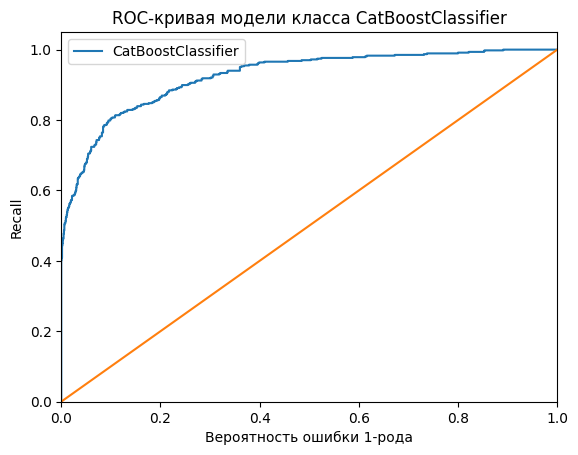

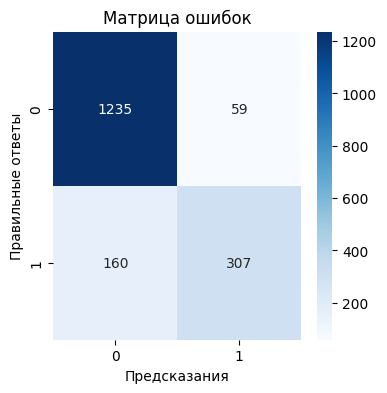

In [95]:
predictions_test = model_cat.predict(features_test)
probabilities_test = model_cat.predict_proba(features_test)[:,1]
fpr, tpr, threshold = roc_curve(target_test, probabilities_test)
    
acc = accuracy_score(target_test, predictions_test)
roc_auc = roc_auc_score(target_test, probabilities_test)
    
print('Класс модели: ', type(model_cat).__name__)
print('Accurasy: ', acc)
print('roc-auc: ', roc_auc)
    
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test, pos_label=1)
plt.plot(fpr, tpr, label=type(model_cat).__name__)
plt.xlabel('Вероятность ошибки 1-рода')
plt.ylabel('Recall')
plt.title('ROC-кривая модели класса ' + type(model_cat).__name__)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend();
    
cmatrix = confusion_matrix(target_test, predictions_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cmatrix, 
              annot=True,  
              cmap='Blues', 
              fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show();

<b>На тестовой выборке модель CatBoost достигла превысила показатели метрики ROC-AUC 0.85 и получила 0.925. Дополнительная метрика Accurasy тоже достаточно высокая - 87,5, она означает точность предсказаний, однако для оценки качества моделей с бинарной классификацией, как в данном случае, часто иcпользуют именно кривую ошибок ROC и оценку площади под ней AUC, которая складывается из соотношений ложно-положительных и положительных ответов.</b>

<b>Теперь проанализирую степень занчимости признаков, участвовавших в обучении модели.</b>

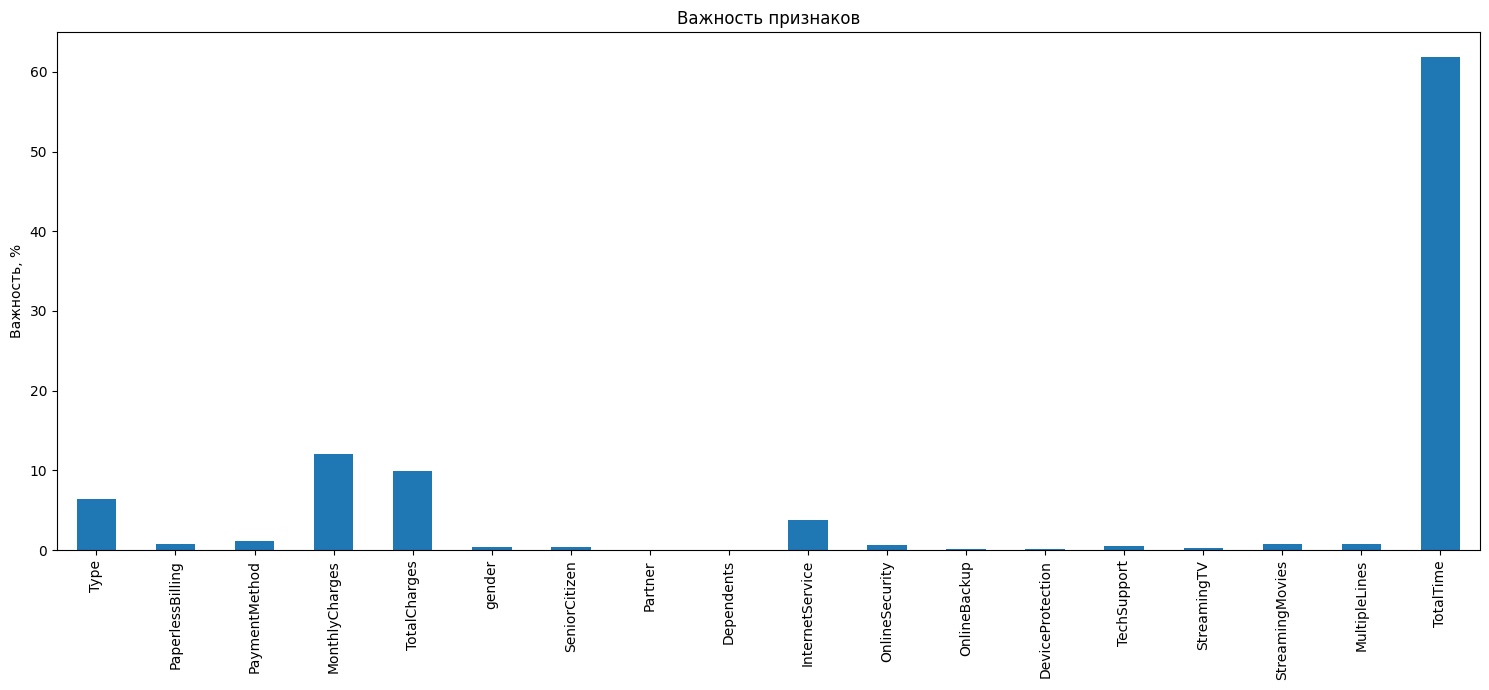

In [109]:
cat_imp = pd.Series(model_cat.get_feature_importance(), df.drop(['target'], axis=1).columns)

fig, ax = plt.subplots(figsize=(15,7))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [110]:
model_cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,TotalTime,61.858419
1,MonthlyCharges,12.015720
2,TotalCharges,9.892859
3,Type,6.425550
4,InternetService,3.819032
5,PaymentMethod,1.086351
6,MultipleLines,0.795727
7,StreamingMovies,0.789377
8,PaperlessBilling,0.740235
9,OnlineSecurity,0.617265


<b>Анализ важности призаков для обучения модели показал, что наибольшее влияние на модель оказывает признак TotalTime, то есть длительность времени, на протяжении которого клиент пользуется услугами компании. Второй по значимости - это признак ежемесячной оплаты, то есть чем дольше клиент пользуется услугами компании и чем больше его ежемесячный платеж, тем наимее вероятно он уйдет. Однако вначале анализа было заметно, что отток клиентов во многом происходил именно из категории тех, у кого ежемесячный платеж тоже был достаточно высоким. Поэтому я считаю, что предложения для клиентов, которые должны стимулировать их не расторгать договор, должны быть направлены в первую очередь на новых клиентов, то есть важнейшим является фактор времени договора.</b>

# Итоговый отчет.

<b>При выполнении работы все пункты плана были выполнены:</b>

1. Загзка данных.

2. Ознакомление с содержанием и качеством информации.

3. Анализ данных.

4. Подготовка данные к обучению, создание новых необхоимых признаков и выделение целевого признака, обрабработка категориальных признаков методом OneHotCoder.

5. Обучение трех моделей, используя кросс-валидацию для поучения лучших метрик.

6. Анализ точности предсказаний: метрики ROC-AUC и Accuracy.

7. Финальный отчет о выполнении проекта.

<b>1. Были загружены и рассмотрены таблицы с данными:</b>

•	contract;

•	internet;

•	personal;

•	phone.

<b> 2. Знакомство с содержанием и качеством информации.</b>
<b>Данные состоят из информации о 7043 клиентах и заключенных с ними договорах, из которых пользователей интернета - 5517, пользователей телефона - 6361. Пропусков и дубликатов не найдено.</b>

<b>3. Анализ данных.</b>
<b>Мною были объединены все талицы о одну, а также была проведена предобработка данных:</b>

1.	BeginDate – поле приведено к типу datetime;

2.	EndDate – для значений "No" установлена "заглушка", соответствующая дате актуальности датасета - 2020-02-01), после чего поле было приведено к формату datetime;

3.	Все признаки, у который были бинарные значения, я привела к целочислительному типу для последующего обучения моделей;

4.	Заполнила пропуски, которые появились в результате объединения таблиц.

Из статистических характеристик объедененного датафрейма можно выделить интересные особенности:
•	у целевого признака очень большая корреляция с общим временем пользованием услугами компании, новые клиенты уходят значительно чаще тех, кто пользуется услугами дано;
•	среднее значение месячных трат практически совпадает с медианным значением, то есть имеет распределение с небольшим отрицательным смещением;
•	распределение значений суммарных трат наоборот, сильное положительное смещение - медиана практически на 40% меньше среднего, это связано и с тем, что некоторые новые пользователи еще не вносили оплату за услуги, а также, возможно, с тем, что кто-то платит помесяно, а кто-то оплачивает сразу год или два;
•	относительно демографии: 16% пенсионеров, 48% имеют супруга(у), у 29% клиентов имеются иждевенцы. Баланс классов гендера соблюдается.

По распределению значений месячных трат выделяются три основные группы клиентов:
    
    от 10 до 40 (base);
    
    от 40 до 80 (standart);
    
    от 80 до 12 (high).
    
Проанализировав данные по группам видно, что клиенты третей группы больше пользуются услугами. Первая группа практически вообще не пользуется дополнительными услугами (доля не превшает 10%).

Примечательно, что:

• доля пользователей, использующих безналичный расчет растет от 38% в первой группе, до 62% во второй группе, и до 76% в третьей группе;

• среди третьей группы больше пенсионеров (7% первая группа, 16% - вторая группа, 25% - третья группа);

• в третей группе больше клиентов, состоящих в браке (43,5% первая группа, 44,7% - вторая группа, 56,6% - третья группа);

• иждевенцев, наоборот, больше в первой группе - 36%, во второй группе 28%, в третьей 25,6%;

• среди третьей группы только 7% пользователей продолжают использовать интернет соединение через через телефонную линию, во второй группе это значение вырастает до 59%, в третьей 38%.</b>

<b>И самое важное: наибольший процент оттока клиентов самый наблюдается в группе  - 34%, во второй группе 29,6%, в первой 15,8%. Хотя показатель общего времени договора тоже самый высокий в среднем в группе с максимальной помесячной оплатой. То есть опять возникает впечатление, что отток составляют те клиенты, которые пришли недавно, платили много, и их это не утроило. А те клиенты, у которых помесячная оплата высокая, которые пользуются дополнительноыми услугами, но пришли давно, сохраняют лояльность.</b>

<b>4. Подготовка данные к обучению, создание новых необхоимых признаков и выделение целевого признака, обрабработка категориальных признаков методом OneHotCoder.</b>

Был выделен целевой признак, имеет место дисбаланс классов (74/26). Эту проблему я решила с помощью встроенный параметров моделей class_weight='balanced'.
Сгенерировала дополнительный признак - длительность использования услуг компании в днях.

<b>5. Обучение моделей трех моделей, используя кросс-валидацию и GridSearchCV.</b>

Я обучила три разных модели с задачами классификации: Логистичсекая регрессия, Случайный лес и CatBoost c использованием метода подбора оптимальных параметров GridSearchCV и с применением кросс-валидации.
Для моделей Логистичсекая регрессия и Случайный лес я применила кодирование категориальных данных с помощью OHE, для CatBoost такой способ не требуется, потому что у этой модели есть встроенный метод обработки категориальных данных.
Для Логистической регрессии я применила также масштабирование данных методом StandardScaler.
Основной для оценки качества модли была метрика ROC-AUC, дополнительной Accurasy. При обучении моделей две из них показали результат основной метрики выше заданой (0,85): Логистичсекая регрессия - 0,86 и CatBoost - 0,928. Лучшая модель CatBoost была протестирована на тестовой выборке, где ей удалось дастигнуть показателя ROC-AUC 0,93.


<b>6. Анализ точности предсказаний лучшей из обученных модели: метрики ROC-AUC и Accuracy.</b>

<b>Модель  CatBoost была протестирована мной на тестовой выборке с построением ROC-кривой и матрицы ошибок.</b>

<b>Также я проанализировала призаки по степени их значимости для обучения модели и выделила 5 наиболее значимых в процентах:</b>
    
    
<b>1.	TotalTime - 68.503640</b>

<b>2.	TotalCharges - 9.144350</b>

<b>3.	MonthlyCharges - 8.600299</b>

<b>4.	Type - 5.727633</b>

<b>5	InternetService	- 2.517605</b>


<b>Анализ важности призаков для обучения модели совпадает с анализом данных: наиболее важным оказался признак продожительности договора. Второй по значимости с сильным отрывом - это признак суммарных трат, здесь вероятно имеет влияние тот фактор, что клиенты, которые сразу оплачивают год или два авансом, реже будут уходить. На третьм месте признак ежемесячной оплаты, то есть чем его ежемесячный платеж, тем наимее вероятно он уйдет. 5,7 %  - тип оплаты, связь здесь возможно такая же, как и в общих тратах, при авасовом платеже на долгий период, клиент уйдет с меньшей вероятностью, и совсем маленькое значение 2,5 % показывает наличие или отсутствие интернет сервиса, как признака, влияющего на решение клиенты об уходе.</b>

<b>7. Финальный отчет о выполнении проекта.</b>

<b>Написала фианльный отчет о выполнении проекта.</b>

<b>В ходе проекта у меня возникли сложности с применением метода автоматичсекого подбора параментров моделей GridSearchCV и методом кодирования категориальных данных OHE. Плохо понимала, как правильно применять, в ходе работы разобралась. </b>

<b>В итоге наилучшей обученной моделью в данном проекте стала модель CatBoostClassifier с параметрами:</b>

In [100]:
best_grid_c

{'boosting_type': 'Ordered',
 'custom_loss': 'AUC',
 'learning_rate': 0.15,
 'n_estimators': 1500,
 'random_state': 300123,
 'verbose': 50}